In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#from sklearn.neighbors import NearestNeighbors as NN


In [2]:
#useful constants:
infty = 1e100
current_pair = (-2137, -2137)
wanted_pair = (-2137, -2137)
current_N = -1
dists = []
vecs = []
neigh_number = 1 #will probably be changed during testing

In [3]:
#metrics

#general template:
#arguments: pair of vectors of scores; these vectors should be dictionaries in form {anime_id : rating}

#returns: distance between given vectors

def normalized_dist(x, y) :
    nonzero_indices = x.keys() & y.keys()
    N = len(nonzero_indices)
    
    if(N == 0) :
        return infty #defined at the beginning, check for that
    
    cut_x = np.array([x[ind] for ind in nonzero_indices])
    cut_y = np.array([y[ind] for ind in nonzero_indices])
    diff = cut_x - cut_y
    
    dist = np.sum(diff ** 2) / N
    return dist

def count_common_dist(x, y) :
    nonzero_indices = x.keys() & y.keys()
    N = len(nonzero_indices)
    
    if(N == 0) :
        return infty #defined at the beginning, check for that
    
    return 1.0 / N

def correlation_dist(x, y) :
    nonzero_indices = x.keys() & y.keys()
    N = len(nonzero_indices)
    
    if(N == 0) :
        return infty #defined at the beginning, check for that
    
    cut_x = np.array([float(x[ind]) for ind in nonzero_indices])
    cut_y = np.array([float(y[ind]) for ind in nonzero_indices])
    
    avg_x = np.average(cut_x)
    avg_y = np.average(cut_y)
    
    cut_x -= np.full(N, avg_x)
    cut_y -= np.full(N, avg_y)
    
    dot_x = np.dot(cut_x, cut_x)
    dot_y = np.dot(cut_y, cut_y)
    
    if(min(dot_x, dot_y) < 1e-100) :
        return infty
    
    dist = np.dot(cut_x, cut_y) / np.sqrt(dot_x * dot_y)
    return dist

def cosine_dist(x, y) :
    nonzero_indices = x.keys() & y.keys()
    N = len(nonzero_indices)
    
    if(N == 0) :
        return infty #defined at the beginning, check for that
    
    cut_x = np.array([float(x[ind]) for ind in nonzero_indices])
    cut_y = np.array([float(y[ind]) for ind in nonzero_indices])
    
    dist = np.dot(cut_x, cut_y) / np.sqrt(np.sum(cut_x ** 2) * np.sum(cut_y ** 2))
    return dist


In [4]:
#arguments: 
# x - main vector, vectors - all other vectors
# dist - metric used (function), K - number of neighbors used to calculate the score

#returns list of K (or less if there are less in total) neighbors
def myKNN(x, vectors, dist, update, K) :
    ret = []
    global dists
    global vecs
    global current_N
    
    if(update == True) :
        dists = []
        current_N = len(vectors)
        for i in range(0, current_N) :
            dists.append((dist(x, vectors[i]), i))
        
        dists = sorted(dists)
        vecs = vectors
    
    K = min(K, current_N)
    for i in range(0, K) :
        ret.append(dists[i][1])
    
    return ret
    

In [5]:
#arguments: 
# anime_id - index of user, user_vec - user's ratings as vector, vectors - other users' ratings as vectors
# dist - metric used (function), K - number of neighbors used to calculate the score

# returns score based on nearest neighbours
def KNN_score(anime_id, user_vec, vectors, dist, update, K = 5) :
    global vecs
    neighbors = myKNN(user_vec, vectors, dist, update, K)
    neigh_scores = np.array([vecs[nei][anime_id] for nei in neighbors])
    if(len(neigh_scores) == 0) :
        score = 5.0
    else :
        score = np.average(neigh_scores)
    return score
    

In [6]:
#read the data
records = pd.read_csv('rating.csv')
records = records.to_numpy()

users = 0
animes = 0

for r in records :
    users = max(users, r[0])
    animes = max(animes, r[1])

#print("users:", users, "animes:", animes)


In [7]:
ratings = [0] * (users + 1)
ratings_with_minus_ones = [0] * (users + 1)
count_anime = [0] * (users + 1)
count_users = [0] * (animes + 1)

for i in range(0, users + 1) :
    ratings[i] = dict()
    ratings_with_minus_ones[i] = dict()

#optional: minus_one - new value for all -1s (0 means ignoring them)
def parse_records(minus_one = -1) :
    for r in records :
        user_id, anime_id, rating = r
        if(rating == -1) :
            rating = minus_one
        if(rating != 0) : 
            ratings_with_minus_ones[user_id][anime_id] = rating
            if(rating != -1) :
                ratings[user_id][anime_id] = rating
                count_users[anime_id] += 1
                count_anime[user_id] += 1
                

#argument: anime_id

#returns: list of rating vectors of users who watched anime_id
def cut_records(anime_id, include_minus_ones) :
    result = []
    
    for user in range(1, users + 1) :
        if(anime_id in ratings[user]) :
            if(include_minus_ones == False) :
                result.append(ratings[user])
            else :
                result.append(ratings_with_minus_ones[user])
    
    return result


parse_records()
    

In [8]:
#arguments: user_id, anime_id
#optional: if score should be rounded, if it is for testing purpouse

#returns estimation of the score
def estimate_score(user_id, anime_id, measure = normalized_dist, include_minus_ones = False, rounded = False, test = False) :    
    temp = 0

    if(test == True) :
        temp = ratings[user_id].pop(anime_id, None)
        if(temp == None) :
            print("You sholud test on existing records! (try test = False)")
            return 2137.0
    else :
        if(anime_id in ratings[user_id]) :
            print("Anime already rated (forgot test = False ?)")
            return ratings[user_id][anime_id]
    
    global current_pair
    global wanted_pair
    
    watched = []
    update = False
    
    wanted_pair = (user_id, anime_id)
    
    if(current_pair != wanted_pair) :
        watched = cut_records(anime_id, include_minus_ones)
        update = True
        current_pair = wanted_pair
            
    if(include_minus_ones == False) :
        user_vec = ratings[user_id]
    else :
        user_vec = ratings_with_minus_ones[user_id]
        
    answer = KNN_score(anime_id, user_vec, watched, measure, update, K = neigh_number)
    
    if(test == True) :
        ratings[user_id][anime_id] = temp
    
    if(rounded == True) :
        answer = np.rint(answer)
    return answer

In [9]:
#arguments: two np.array with equal lengths: estimated and expected ratings 

#returns: average of squared differences
def error_avsq(estimated, real) :
    return np.sum((estimated-real)**2) / len(real)


In [10]:
#optional: user_bound, anime_bound, stop_bound

#returns at most stop_bound pairs (user_id, anime_id) such that:
# - used_id watched anime_id and rated it
# - user_id watched at least user_bound animes
# - anime id has been watched at least anime_bound times
def select_popular_probe(user_bound = 30, anime_bound = 5000, stop_bound = 1000) :
    ans = []
    
    perm = np.arange(len(records))
    np.random.shuffle(perm)
    
    for p in perm :
        user_id, anime_id, rating = records[p]
        if(rating > 0 and count_anime[user_id] >= user_bound and count_users[anime_id] >= anime_bound) :
            ans.append((user_id, anime_id))
            if(len(ans) == stop_bound) :
                break
                
    return ans

def select_random_probe(stop_bound = 1000) :
    return select_popular_probe(0, 0, stop_bound)

#optional: user_bound, anime_bound, stop_bound

#returns at most stop_bound pairs (user_id, anime_id) such that:
# - used_id watched anime_id and rated it
# - user_id watched at most user_bound animes
# - anime id has been watched at least anime_bound times
def select_newbies_probe(user_bound = 5, anime_bound = 0, stop_bound = 1000) :
    ans = []
    
    perm = np.arange(len(records))
    np.random.shuffle(perm)
    
    for p in perm :
        user_id, anime_id, rating = records[p]
        if(rating > 0 and count_anime[user_id] <= user_bound and count_users[anime_id] >= anime_bound) :
            ans.append((user_id, anime_id))
            if(len(ans) == stop_bound) :
                break           
    return ans

def select_newbies_popular_probe(stop_bound = 1000) :
    return select_newbies_probe(10, 10000, stop_bound)


#optional: user_bound, anime_bound, stop_bound

#returns at most stop_bound pairs (user_id, anime_id) such that:
# - used_id watched anime_id and rated it
# - user_id watched at least user_bound animes
# - anime id has been watched at most anime_bound times
def select_connoisseur_probe(user_bound = 100, anime_bound = 20, stop_bound = 1000) :
    ans = []
    
    perm = np.arange(len(records))
    np.random.shuffle(perm)
    
    for p in perm :
        user_id, anime_id, rating = records[p]
        if(rating > 0 and count_anime[user_id] >= user_bound and count_users[anime_id] <= anime_bound) :
            ans.append((user_id, anime_id))
            if(len(ans) == stop_bound) :
                break
                
    print(len(ans))
    return ans

In [11]:
#arguments: k - parameter for k nearest neighbors algorithm,
# test_pairs - testset in form of pairs (user_id, anime_id)
#optional: function measuring errors

#prints errors
def make_test(k, test_pairs, measure = normalized_dist, include_minus_ones = False, error_func = error_avsq) :
    estimated = []
    expected = []
    
    estimated.append([])
    expected.append([])
    
    N = len(test_pairs)
    
    for curr_k in range(1, k + 1):
        estimated.append([])
        expected.append([])
    
    i = 1
    for t in test_pairs:
        if(i % 10 == 0) :
            print(i, end = " ")
        user_id, anime_id = t
        
        for curr_k in range(1, k + 1):
            global neigh_number
            neigh_number = curr_k
            estimated[curr_k].append(estimate_score(user_id, anime_id, measure, include_minus_ones, test = True, rounded = False))
            expected[curr_k].append(ratings[user_id][anime_id])
        
        i += 1
    
    for curr_k in range(1, k + 1):
        estimated[curr_k] = np.array(estimated[curr_k])
        expected[curr_k] = np.array(expected[curr_k])
    
    ret = []
    
    for curr_k in range(1, k + 1):
        error = error_func(estimated[curr_k], expected[curr_k])
        ret.append(error)
        
    return np.array(ret)    
    
    

In [12]:
np.random.seed(69)

probe_size = 500

random_probe = select_random_probe(stop_bound = probe_size)
popular_probe = select_popular_probe(stop_bound = probe_size)
newbies_probe = select_newbies_popular_probe(stop_bound = probe_size)
connoisseur_probe = select_connoisseur_probe(stop_bound = probe_size)

np.savetxt('random.txt', random_probe, fmt = '%d')
np.savetxt('popular.txt', popular_probe, fmt = '%d')
np.savetxt('newbies.txt', newbies_probe, fmt = '%d')
np.savetxt('connoisseur.txt', connoisseur_probe, fmt = '%d')


500


In [13]:
k_bound = 200

errors = np.zeros((4, 4, k_bound))

errors[0][0] = make_test(k_bound, random_probe, normalized_dist)
errors[0][1] = make_test(k_bound, random_probe, count_common_dist)
errors[0][2] = make_test(k_bound, random_probe, correlation_dist)
errors[0][3] = make_test(k_bound, random_probe, cosine_dist)

errors[1][0] = make_test(k_bound, popular_probe, normalized_dist)
errors[1][1] = make_test(k_bound, popular_probe, count_common_dist)
errors[1][2] = make_test(k_bound, popular_probe, correlation_dist)
errors[1][3] = make_test(k_bound, popular_probe, cosine_dist)

errors[2][0] = make_test(k_bound, newbies_probe, normalized_dist)
errors[2][1] = make_test(k_bound, newbies_probe, count_common_dist)
errors[2][2] = make_test(k_bound, newbies_probe, correlation_dist)
errors[2][3] = make_test(k_bound, newbies_probe, cosine_dist)

errors[3][0] = make_test(k_bound, connoisseur_probe, normalized_dist)
errors[3][1] = make_test(k_bound, connoisseur_probe, count_common_dist)
errors[3][2] = make_test(k_bound, connoisseur_probe, correlation_dist)
errors[3][3] = make_test(k_bound, connoisseur_probe, cosine_dist)

filenames = ['cf_errors_random.txt', 'cf_errors_popular.txt', 'cf_errors_newbies.txt', 'cf_errors_connoisseur.txt']

for i in range(0, 4) :
    cur = np.array([])
    for j in range(0, 4) :
        #print(cur, errors[i][j])
        cur = np.concatenate((cur, errors[i][j]))
    np.savetxt(filenames[i], cur, fmt = '%.5f')


10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 10 20 30 40 50 60 70 80 90 100 110 120 130 14

/home/zbyszek/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/zbyszek/.local/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 

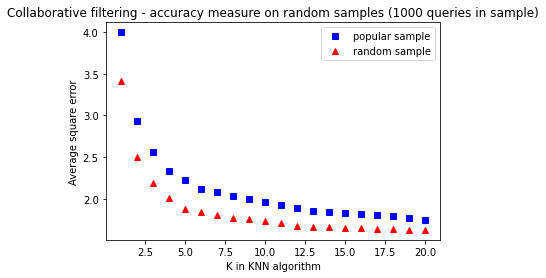

In [14]:
ks = np.arange(1, 21)
errors_popular = [3.999, 2.92875, 2.564333333333333, 2.33825, 2.22516, 2.1125, 2.076183673469388, 2.03540625, 1.994061728395062, 1.95746, 1.9221074380165286, 1.8937013888888892, 1.8582544378698227, 1.8449285714285713, 1.82704, 1.81278515625, 1.7988996539792388, 1.788070987654321, 1.7705706371191137, 1.7491825]
errors_random =  [3.417, 2.49575, 2.1923333333333335, 2.0124375, 1.8742800000000002, 1.8394444444444444, 1.8093673469387757, 1.77153125, 1.7558024691358025, 1.7349400000000001, 1.703495867768595, 1.6764166666666667, 1.6660591715976334, 1.661107142857143, 1.6432253287981862, 1.6437992350481858, 1.6315660900438607, 1.6336039707734944, 1.628074414670762, 1.6252053287981862]

plt.plot(ks, errors_popular, 'bs', label = 'popular sample')
plt.plot(ks, errors_random, 'r^', label = 'random sample')
plt.ylabel('Average square error')
plt.xlabel('K in KNN algorithm')
plt.title('Collaborative filtering - accuracy measure on random samples (1000 queries in sample)')
plt.legend()
plt.show()